In [ ]:
!pip install ipyplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.utils import shuffle
import ipyplot
from tensorflow.keras.layers import*
from tensorflow.keras.models import*
from tensorflow.keras.losses import*
from tensorflow.keras.optimizers import*
import os
import math
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
training_label_path = '/content/drive/MyDrive/gibbor_filter/labels_new_geyepac_train.npy'
training_file_path = '/content/drive/MyDrive/gibbor_filter/arr_new_geyepac_train.npy'
testing_file_path = '/content/drive/MyDrive/gibbor_filter/arr_new_geyepac_test.npy'
testing_label_path = '/content/drive/MyDrive/gibbor_filter/labels_new_geyepac_test.npy'

training_images,training_labels,testing_images,testing_labels=np.load(training_file_path),np.load(training_label_path),np.load(testing_file_path),np.load(testing_label_path)
print("shape of training data",training_images.shape,",",training_labels.shape)
print("shape of testing data",testing_images.shape,",",testing_labels.shape)

shape of training data (9250, 224, 224, 3) , (9250, 5)
shape of testing data (667, 224, 224, 3) , (667, 5)


In [ ]:
training_images, training_labels = shuffle(training_images, training_labels)
testing_images, testing_labels = shuffle(testing_images, testing_labels)


In [ ]:
classes = 5

#model

inputs = Input((224,224,3))

conv1 = Conv2D(8,3,activation = 'relu', padding = 'valid')(inputs)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

conv2 = Conv2D(16,3,activation = 'relu', padding = 'valid')(pool1)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)


conv3 = Conv2D(32,3,activation = 'relu', padding = 'valid')(pool2)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

# conv4 = Conv2D(64,3,activation = 'relu', padding = 'same')(pool3)
# conv4 = BatchNormalization()(conv4)
# pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

conv5 = Conv2D(128,3,activation = 'relu', padding = 'valid')(pool3)
conv5 = BatchNormalization()(conv5)
drop5 = Dropout(0.25)(conv5)
x = GlobalAveragePooling2D()(drop5)
x = Dense(128,activation = 'relu', name = 'Dense_1', dtype='float32')(x)
x = Dense(64,activation = 'relu', name = 'Dense_2', dtype='float32')(x)
x = Dense(8,activation = 'relu', name = 'Dense_3', dtype='float32')(x)
x = Dense(classes,activation = 'softmax', name = 'Output', dtype='float32')(x)

my_model = Model(inputs = [inputs], outputs=[x])

my_optimiser = Adam(lr = 0.00001)
my_model.compile(loss='categorical_crossentropy',optimizer = my_optimiser,metrics = ['categorical_accuracy'])
print("done")
my_model.summary()



done
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 8)       32        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)     

In [ ]:
def decaying_cosine_annealing_scheduler(epoch):
    """
        A step rate scheduler for setting the learning rate for each epoch.
        :param epoch: current epoch
        :return: learning rate for current epoch
        """

    learning_rate_min = 1e-6
    original_learning_rate_max = 1e-3
    original_cycle_length = 15
    epochs_per_cycle = original_cycle_length-(int(epoch/original_cycle_length))
    learning_rate_max = original_learning_rate_max/((int(epoch/original_cycle_length))+1)
    #print(learning_rate_max,learning_rate_min, epoch, epochs_per_cycle)

    return learning_rate_min + (learning_rate_max - learning_rate_min) * \
           (1 + math.cos(math.pi * (epoch % epochs_per_cycle) / epochs_per_cycle)) / 2

In [ ]:

major_revision, minor_revision = 2,1
model_save_path = "/content/drive/MyDrive"
log_save_path =  "/content/drive/MyDrive"


file_path = os.path.join(model_save_path, 'm%i-%i.h5' % (major_revision, minor_revision))
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(file_path, monitor= 'val_categorical_accuracy', verbose = 1, mode='max', save_best_only=True, save_freq='epoch')

learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(decaying_cosine_annealing_scheduler, verbose=True)


file = open(os.path.join(log_save_path, 'log-%i-%i.txt' % (major_revision, minor_revision)),'a+')

text_logging_callback = tf.keras.callbacks.LambdaCallback(
on_epoch_end=lambda epoch, logs: file.write('####EPOCH %i\n' % (epoch + 1) + '#### VALIDATION ACCURACY =%.5f \n' % logs['val_categorical_accuracy'])
)

my_callbacks = [checkpoints_callback, learning_rate_callback, text_logging_callback]

In [ ]:
epochs = 50

my_model_history = my_model.fit(x=training_images,y=training_labels,epochs = epochs,callbacks=my_callbacks,validation_split=0.1)

file.close()


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
261/261 [==============================] - ETA: 0s - loss: 1.5757 - categorical_accuracy: 0.2563
Epoch 1: val_categorical_accuracy improved from -inf to 0.26054, saving model to /content/drive/MyDrive/m2-1.h5
261/261 [==============================] - 16s 43ms/step - loss: 1.5757 - categorical_accuracy: 0.2563 - val_loss: 1.5704 - val_categorical_accuracy: 0.2605 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000989084726566536.
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


259/261 [============================>.] - ETA: 0s - loss: 1.4793 - categorical_accuracy: 0.3446
Epoch 2: val_categorical_accuracy improved from 0.26054 to 0.33514, saving model to /content/drive/MyDrive/m2-1.h5
261/261 [==============================] - 10s 38ms/step - loss: 1.4796 - categorical_accuracy: 0.3444 - val_loss: 1.5065 - val_categorical_accuracy: 0.3351 - lr: 9.8908e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009568159560924792.
Epoch 3/50
261/261 [==============================] - ETA: 0s - loss: 1.3876 - categorical_accuracy: 0.3793
Epoch 3: val_categorical_accuracy did not improve from 0.33514
261/261 [==============================] - 10s 39ms/step - loss: 1.3876 - categorical_accuracy: 0.3793 - val_loss: 1.7575 - val_categorical_accuracy: 0.3103 - lr: 9.5682e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009046039886902864.
Epoch 4/50
261/261 [==============================] - ETA: 0s - loss: 1.3495 - categorical_accuracy: 0.3981
E

In [ ]:
model_messidor = tf.keras.models.load_model('/content/drive/MyDrive/internship/model_norm/m1-11.h5')

20/20 [==============================] - 1s 13ms/step
(624, 5)


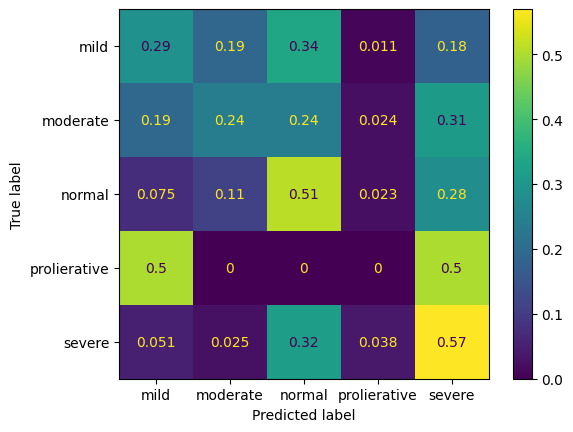

In [ ]:

my_predictions = model_messidor.predict(testing_images)
print(my_predictions.shape)
classes = ['mild','moderate','normal','prolierative','severe']
#classes = ['normal', 'mild', 'moderate', 'severe', 'proliferative']

conf_matrix = confusion_matrix(list(np.argmax(testing_labels, axis=1)), list(np.argmax(my_predictions, axis=1)))
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

cmd = ConfusionMatrixDisplay(normalized_conf_matrix, display_labels=classes)
cmd.plot()


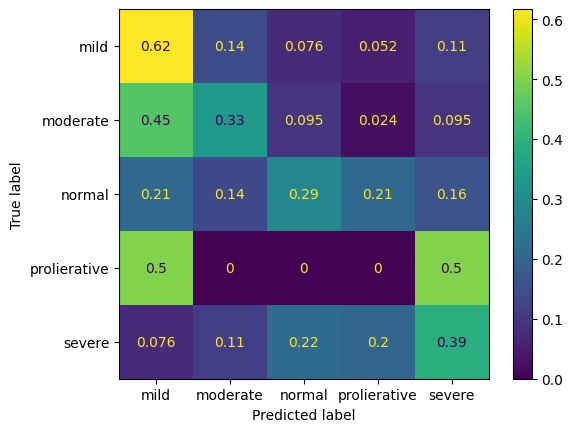

In [ ]:
testing_file_path2 = '/content/drive/MyDrive/test_set/myarr_testnew.npy'
testing_label_path2 = '/content/drive/MyDrive/test_set/newlabels_test.npy'
testing_images2,testing_labels2=np.load(testing_file_path2),np.load(testing_label_path2)

testing_images2,testing_labels2 = shuffle(testing_images2,testing_labels2)


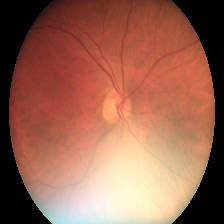
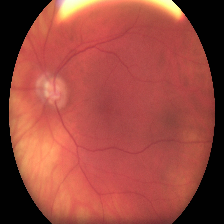
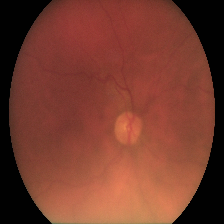
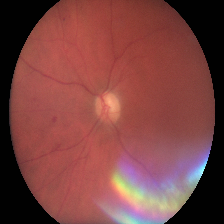
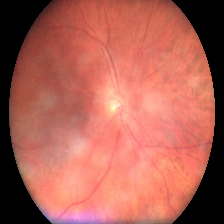
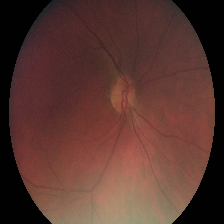
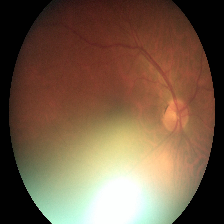
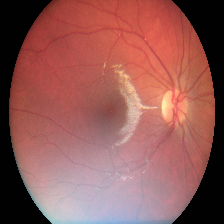
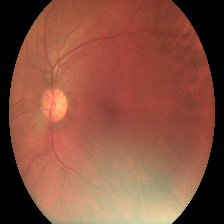
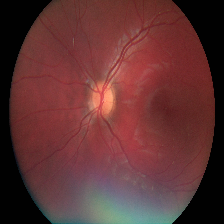


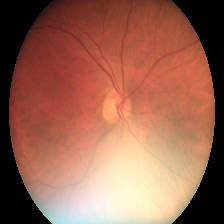
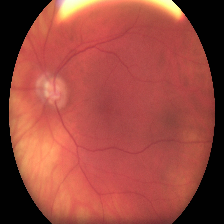
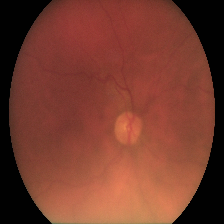
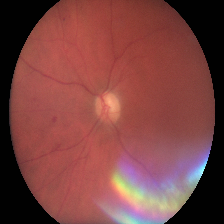
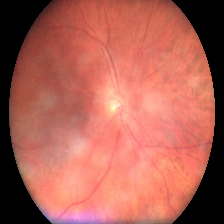
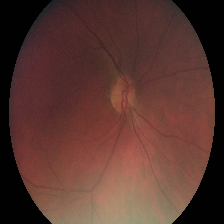
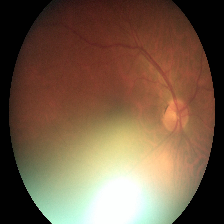
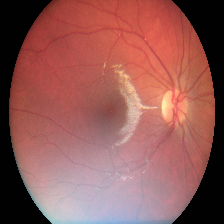
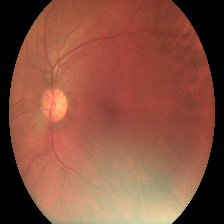
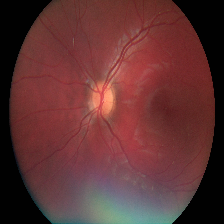

[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]]


In [ ]:
ipyplot.plot_images(testing_images2[:,:,:,::-1],max_images = 10, img_width = 100)
print(testing_labels2[:10])

20/20 [==============================] - 0s 8ms/step
(624, 5)


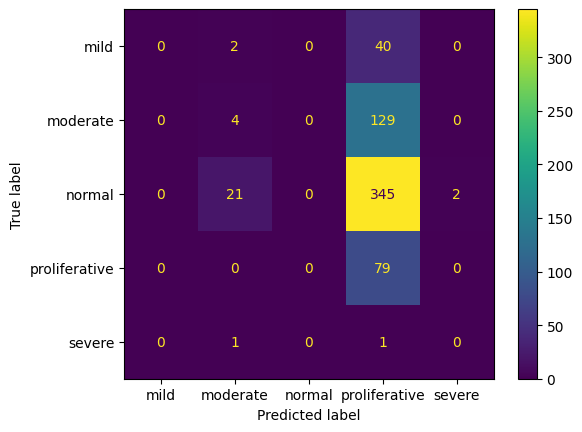

In [ ]:
my_predictions = my_model.predict(testing_images2)
print(my_predictions.shape)
classes = ['mild','moderate','normal','proliferative','severe']
cmd = ConfusionMatrixDisplay((confusion_matrix(list(np.argmax(testing_labels2, axis=1)), list(np.argmax(my_predictions, axis=1)))), display_labels=classes)

cmd.plot()
plt.show()

In [ ]:
classes = ['mild','moderate','normal','proliferative','severe']

# Desired order of class labels (for example, changing the order)
desired_classes_order = ['normal', 'mild', 'moderate', 'severe', 'proliferative']

# Assuming your

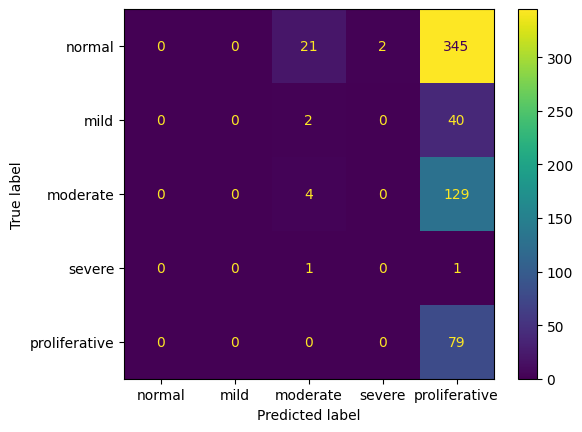

In [ ]:

# Creating a confusion matrix based on the desired order of class labels
confusion = confusion_matrix(
    list(np.argmax(testing_labels2, axis=1)),
    list(np.argmax(my_predictions, axis=1))
)

# Reordering the confusion matrix rows and columns
reordered_confusion = np.zeros_like(confusion)
for i in range(len(classes)):
    idx_i = classes.index(desired_classes_order[i])
    for j in range(len(classes)):
        idx_j = classes.index(desired_classes_order[j])
        reordered_confusion[i, j] = confusion[idx_i, idx_j]

# Plotting the confusion matrix with the desired order of class labels
cmd = ConfusionMatrixDisplay(
    reordered_confusion,
    display_labels=desired_classes_order
)
cmd.plot()
plt.show()

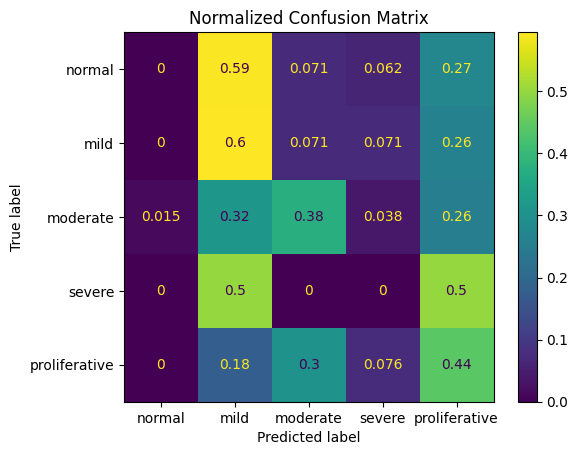

In [ ]:


# Creating a confusion matrix based on the desired order of class labels
confusion = confusion_matrix(
    list(np.argmax(testing_labels2, axis=1)),
    list(np.argmax(my_predictions, axis=1))
)

# Reordering the confusion matrix rows and columns
reordered_confusion = np.zeros_like(confusion)
for i in range(len(classes)):
    idx_i = classes.index(desired_classes_order[i])
    for j in range(len(classes)):
        idx_j = classes.index(desired_classes_order[j])
        reordered_confusion[i, j] = confusion[idx_i, idx_j]

# Normalize the confusion matrix by dividing each row by its sum
row_sums = reordered_confusion.sum(axis=1, keepdims=True)
normalized_confusion = reordered_confusion / row_sums

# Plotting the normalized confusion matrix with the desired order of class labels
cmd = ConfusionMatrixDisplay(
    normalized_confusion,
    display_labels=desired_classes_order
)
cmd.plot()  # You can change the colormap if desired
plt.title("Normalized Confusion Matrix")
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/internship/model2/m2-1.h5')


In [ ]:
testing_file_path3 = '/content/drive/MyDrive/myarr_testnew_256.npy'
testing_label_path3 = '/content/drive/MyDrive/newlabels_test_256.npy'
testing_images3,testing_labels3=np.load(testing_file_path3),np.load(testing_label_path3)

testing_images3,testing_labels3 = shuffle(testing_images3,testing_labels3)


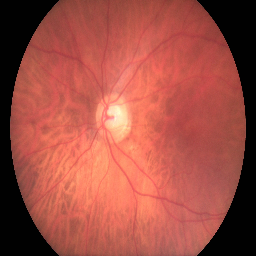
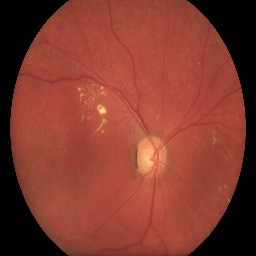
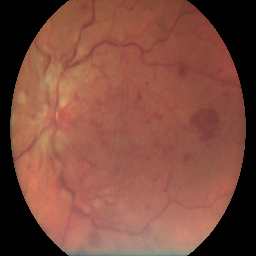
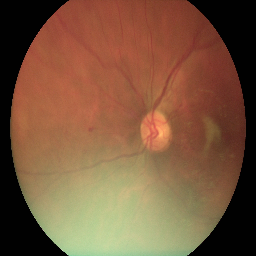
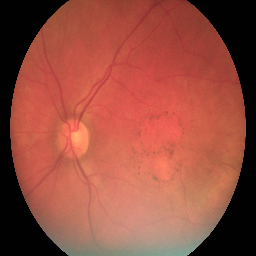
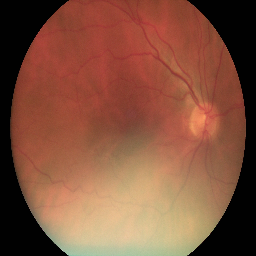
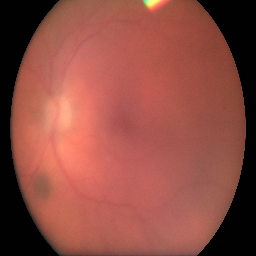
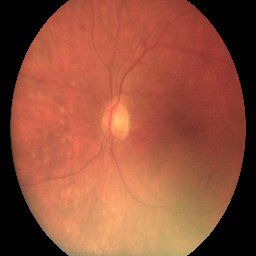
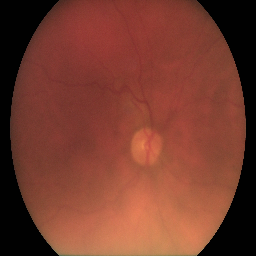
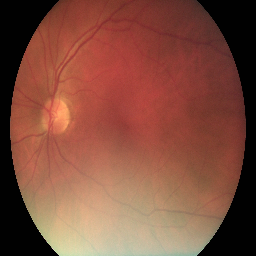


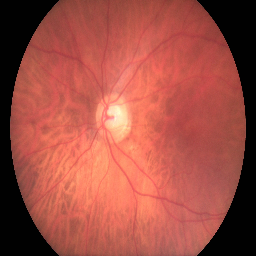
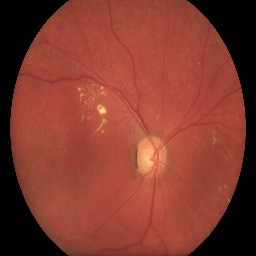
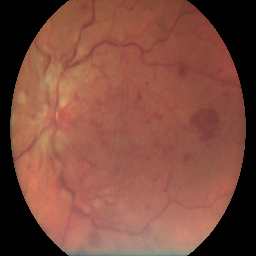
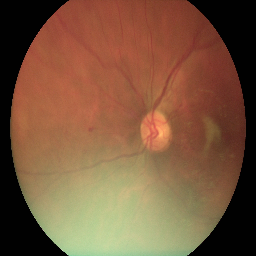
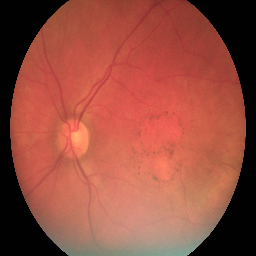
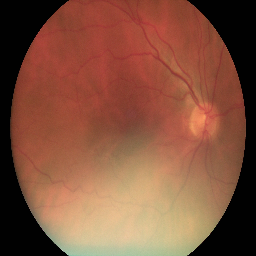
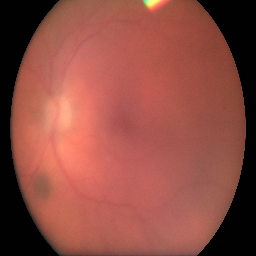
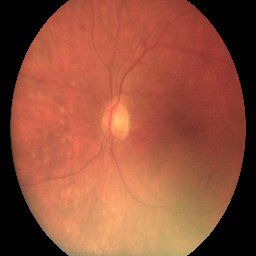
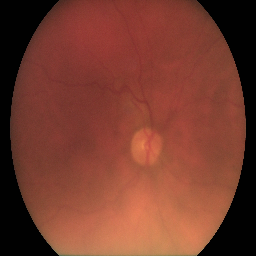
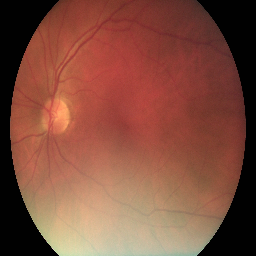

[[0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]]


In [ ]:
ipyplot.plot_images(testing_images3[:,:,:,::-1],max_images = 10, img_width = 100)
print(testing_labels3[:10])

20/20 [==============================] - 0s 10ms/step
(624, 5)


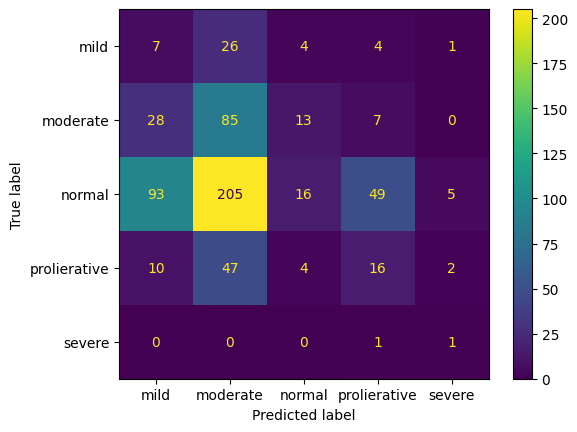

In [ ]:
my_predictions = model.predict(testing_images3)
print(my_predictions.shape)
classes = ['mild','moderate','normal','prolierative','severe']
#classes = ['normal', 'mild', 'moderate', 'severe', 'proliferative']
cmd = ConfusionMatrixDisplay((confusion_matrix(list(np.argmax(testing_labels3, axis=1)), list(np.argmax(my_predictions, axis=1)))), display_labels=classes)
cmd.plot()
plt.show()

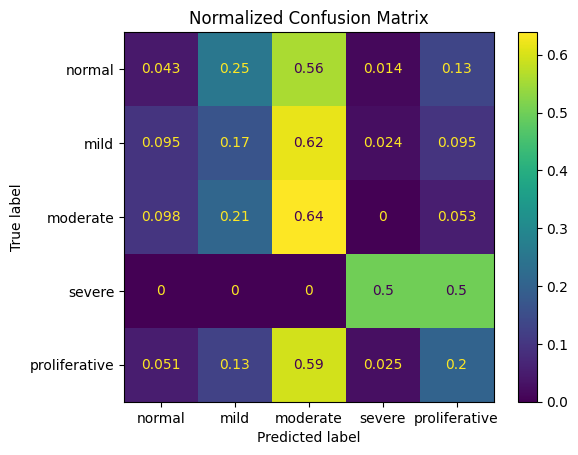

In [ ]:
classes = ['mild','moderate','normal','proliferative','severe']

# Desired order of class labels (for example, changing the order)
desired_classes_order = ['normal', 'mild', 'moderate', 'severe', 'proliferative']

# Assuming your
# Creating a confusion matrix based on the desired order of class labels
confusion = confusion_matrix(
    list(np.argmax(testing_labels3, axis=1)),
    list(np.argmax(my_predictions, axis=1))
)

# Reordering the confusion matrix rows and columns
reordered_confusion = np.zeros_like(confusion)
for i in range(len(classes)):
    idx_i = classes.index(desired_classes_order[i])
    for j in range(len(classes)):
        idx_j = classes.index(desired_classes_order[j])
        reordered_confusion[i, j] = confusion[idx_i, idx_j]

# Normalize the confusion matrix by dividing each row by its sum
row_sums = reordered_confusion.sum(axis=1, keepdims=True)
normalized_confusion = reordered_confusion / row_sums

# Plotting the normalized confusion matrix with the desired order of class labels
cmd = ConfusionMatrixDisplay(
    normalized_confusion,
    display_labels=desired_classes_order
)
cmd.plot()  # You can change the colormap if desired
plt.title("Normalized Confusion Matrix")
plt.show()